# code : https://keras.io/examples/vision/image_classification_from_scratch/

# download data

In [2]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
# !unzip -q kagglecatsanddogs_5340.zip
# !ls
# import os
# num_skipped = 0
# for folder_name in ("Cat", "Dog"):
#     folder_path = os.path.join("PetImages", folder_name)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print("Deleted %d images" % num_skipped)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!ls PetImages

Cat Dog


In [4]:
@tf.function
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    return x
data_augmentation = keras.Sequential(
    [
        layers.Lambda(lambda x: random_invert_img(x, 0.1)),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)

In [5]:
image_size = (180, 180)
batch_size = 16
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",validation_split=0.2,seed=42,
    subset="both",image_size=image_size,batch_size=batch_size)
print(train_ds.class_names)

Found 23411 files belonging to 2 classes.
Using 18729 files for training.
Using 4682 files for validation.
['Cat', 'Dog']


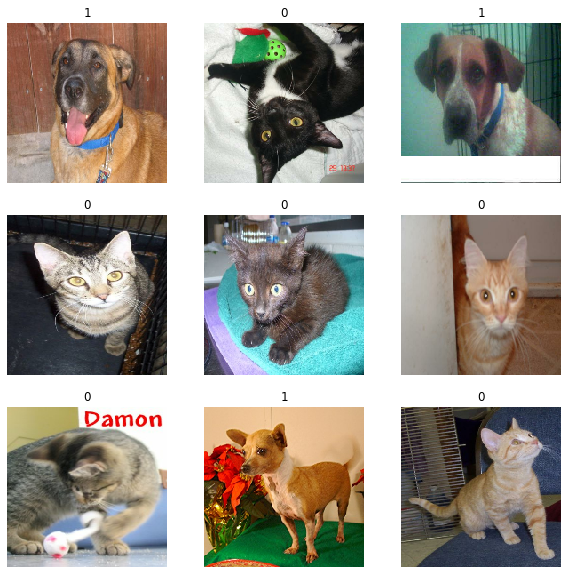

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
strategy = tf.distribute.get_strategy() 
# tf.distribute.get_strategy() -> cpu  | tf.distribute.TPUStrategy -> tpu | 
# tf.distribute.MirroredStrategy() -> multigpu | tf.distribute.MultiWorkerMirroredStrategy() -> multiworker
# --------------------------------------------------------------
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
# --------------------------------------------------------------
train_ds = strategy.experimental_distribute_dataset(train_ds)
val_ds = strategy.experimental_distribute_dataset(val_ds)

In [8]:
class ModelCustom(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")
        self.dp1 = tf.keras.layers.Dropout(0.2)
        self.dense1 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

    def call(self, inputs):
        x = inputs 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dp1(x)
        x = self.maxpool1(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        out = self.dense1(x)
        return out

In [9]:
with strategy.scope(): # can be a different strategy than data strategy
    model = ModelCustom()
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",metrics=["accuracy"])

In [10]:
pr = model.predict(train_ds.take(1))

1/1 [==============================] - 1s 997ms/step


In [11]:
model.summary()

Model: "model_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3584      
                                                                 
 batch_normalization (BatchN  multiple                 512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  129       
                                                                 
Total params: 4,225
Trainable params: 3,969
Non-traina

In [12]:
epochs = 1
model.fit(train_ds,epochs=epochs,validation_data=val_ds,
          steps_per_epoch=18729//batch_size,validation_steps=4682//batch_size
         )

1170/1170 [==============================] - 495s 423ms/step - loss: 0.6636 - accuracy: 0.5947 - val_loss: 0.8261 - val_accuracy: 0.5073


In [16]:
tf.keras.models.save_model(model,'./model')

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets
